# Root Cause Analysis for Late Deliveries in a Supply Chain
The following dataset is for an online retail store whose product delivery was a concern. The dataset is about the linear supply chain that they follow.

Essentially, there are 4 steps involved in this process
1. Planning - Assign a date the customer can expect to receive their order - Date planned 
2. Sourcing  
3. Making 
4. Delivery

The dataset was provided with the end timestamps for each of these steps along with their deadlines and other self explained attributes. 
 

## Preliminary Data Analysis and Conclusions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
df = pd.read_excel('CASE STUDY_DATA_LATE DELIVERY ROOT CAUSE.xlsx')

In [3]:
df.head()

,order_id,country,shipping_method,units_per_order,facility,product_category,on_sale,transit_days,returned,backorder,datetime_ordered,datetime_sourced,datetime_product_ready,datetime_planned,datetime_delivered,deadline_source,deadline_make,deadline_deliver,delivered_to_plan
0,E00000001,UNITED KINGDOM,Ground,1,OXFORD,ACCESSORIES,Y,2,NaN,NaN,2016-07-03 03:07:29,2016-07-03 04:09:49,2016-07-06 00:59:42,2016-07-08,2016-07-07,1612,38,3,PASS
1,E00000002,FRANCE,Ground,1,ANTWERP,JACKETS & VESTS,N,3,Y,NaN,2016-07-03 00:08:43,2016-07-03 02:16:24,2016-07-03 07:17:04,2016-07-06,2016-07-05,531,8,3,PASS
2,E00000003,FRANCE,Ground,1,ANTWERP,TOPS,Y,3,NaN,NaN,2016-07-03 00:36:00,2016-07-03 02:16:18,2016-07-03 06:16:57,2016-07-06,2016-07-05,504,8,3,PASS
3,E00000004,FRANCE,Ground,1,ANTWERP,JACKETS & VESTS,Y,5,NaN,NaN,2016-07-03 00:47:45,2016-07-03 02:16:18,2016-07-03 06:16:55,2016-07-07,2016-07-05,492,8,5,PASS
4,E00000005,UNITED KINGDOM,Next Day,1,OXFORD,JACKETS & VESTS,Y,1,NaN,NaN,2016-07-03 03:52:13,2016-07-03 07:56:33,2016-07-05 08:53:19,2016-07-06,2016-07-06,1567,6,1,PASS


In [4]:
df.columns

Index(['order_id', 'country', 'shipping_method', 'units_per_order', 'facility',
       'product_category', 'on_sale', 'transit_days', 'returned', 'backorder',
       'datetime_ordered', 'datetime_sourced', 'datetime_product_ready',
       'datetime_planned', 'datetime_delivered', 'deadline_source',
       'deadline_make', 'deadline_deliver', 'delivered_to_plan'],
      dtype='object')

## Data Cleaning and Preprocessing

In this process, I have checked for nulls in each column. For the boolean attributes 'returned' and 'backorder', since there were only 'Y' values in the data, the other missing values were assumed to be 'N'. 

Therefore, the null values in those attributes have been replaced with 'N'.


In [5]:
for col in df.columns:
    if df[col].isna().sum()>0:
        print(col, df[col].isna().sum())

returned 94723
backorder 98004


In [6]:
df['returned'].unique()

array([nan, 'Y'], dtype=object)

In [7]:
df['returned'] = df['returned'].fillna('N')

In [8]:
df['backorder'].unique()

array([nan, 'Y'], dtype=object)

In [9]:
df['backorder'] = df['backorder'].fillna('N')

## Checking the distribution for each factor

### 1. Country

In [10]:
df_pivot_country = df.pivot_table(values='order_id',index='country',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_country['Total']=df_pivot_country['FAIL']+df_pivot_country['PASS']
df_pivot_country['% Pass'] = (df_pivot_country['PASS']/df_pivot_country['Total'])*100
df_pivot_country['% Fail'] = (df_pivot_country['FAIL']/df_pivot_country['Total'])*100
df_pivot_country

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
country,,,,,
BELGIUM,110,368,478,76.987448,23.012552
FRANCE,1082,9171,10253,89.446991,10.553009
GERMANY,6703,55061,61764,89.147400,10.852600
NETHERLANDS,50,428,478,89.539749,10.460251
SWEDEN,223,2211,2434,90.838127,9.161873
UNITED KINGDOM,3423,31284,34707,90.137436,9.862564


From the above summary, it is clear that Belgium has the highest fail rate. We need to explore other factors regarding Belgium - how are other factors influencing Belgium failure rate. For this we need to explore the trend in the failures in Belgium, other factors in Belgium such as shipping method, facility or product category etc. 

This is done later, after all the new features were derived.

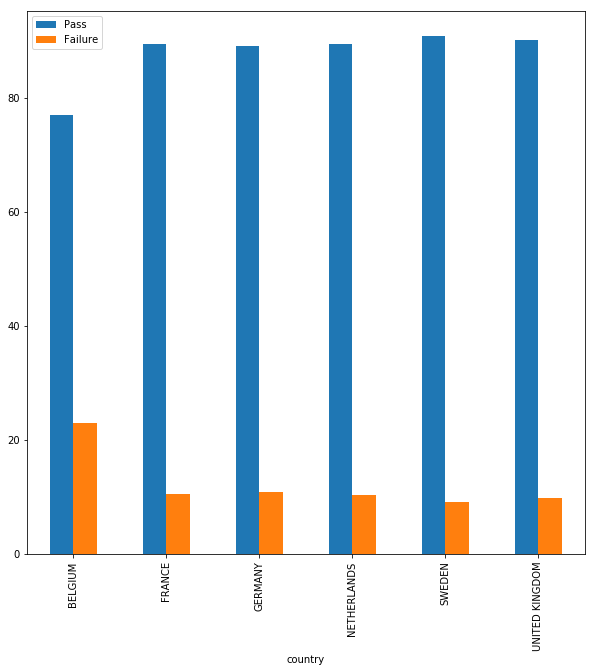

In [11]:
pd.DataFrame(np.c_[df_pivot_country['% Pass'],df_pivot_country['% Fail']], 
             index=df_pivot_country.index).plot(kind='bar',figsize=(10,10))
plt.legend(['Pass','Failure'])

### 2. Shipping Method

In [12]:
df_pivot_shipping = df.pivot_table(values='order_id',index='shipping_method',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_shipping['Total']=df_pivot_shipping['FAIL']+df_pivot_shipping['PASS']
df_pivot_shipping['% Pass'] = (df_pivot_shipping['PASS']/df_pivot_shipping['Total'])*100
df_pivot_shipping['% Fail'] = (df_pivot_shipping['FAIL']/df_pivot_shipping['Total'])*100
df_pivot_shipping

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
shipping_method,,,,,
2-Day,663,2529,3192,79.229323,20.770677
3-Day,1780,13695,15475,88.497577,11.502423
Ground,6993,69828,76821,90.897020,9.102980
Next Day,2155,12471,14626,85.265965,14.734035


There is a clear increase in the failure a 2-Day shipping method when compared to other methods. There may be other factors influencing this factor. 

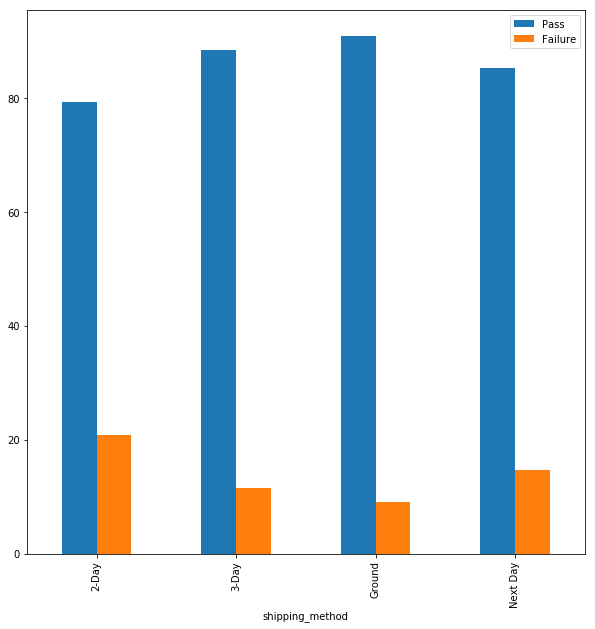

In [13]:
pd.DataFrame(np.c_[df_pivot_shipping['% Pass'],df_pivot_shipping['% Fail']], 
             index=df_pivot_shipping.index).plot(kind='bar',figsize=(10,10))
plt.legend(['Pass','Failure'])

### 3. Units_per_order

In [14]:
df_pivot_units = df.pivot_table(values='order_id',index='units_per_order',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_units['Total']=df_pivot_units['FAIL']+df_pivot_units['PASS']
df_pivot_units['% Pass'] = (df_pivot_units['PASS']/df_pivot_units['Total'])*100
df_pivot_units['% Fail'] = (df_pivot_units['FAIL']/df_pivot_units['Total'])*100
df_pivot_units

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
units_per_order,,,,,
1,11247.0,96444.0,107691.0,89.556230,10.443770
2,198.0,1440.0,1638.0,87.912088,12.087912
3,58.0,351.0,409.0,85.819071,14.180929
4,27.0,85.0,112.0,75.892857,24.107143
5,23.0,77.0,100.0,77.000000,23.000000
6,9.0,50.0,59.0,84.745763,15.254237
7,5.0,11.0,16.0,68.750000,31.250000
8,2.0,8.0,10.0,80.000000,20.000000
9,1.0,7.0,8.0,87.500000,12.500000


In [15]:
df_pivot_units=df_pivot_units.dropna(how='any')
df_pivot_units

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
units_per_order,,,,,
1,11247.0,96444.0,107691.0,89.556230,10.443770
2,198.0,1440.0,1638.0,87.912088,12.087912
3,58.0,351.0,409.0,85.819071,14.180929
4,27.0,85.0,112.0,75.892857,24.107143
5,23.0,77.0,100.0,77.000000,23.000000
6,9.0,50.0,59.0,84.745763,15.254237
7,5.0,11.0,16.0,68.750000,31.250000
8,2.0,8.0,10.0,80.000000,20.000000
9,1.0,7.0,8.0,87.500000,12.500000


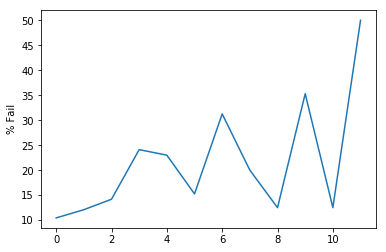

In [16]:
sns.lineplot(range(0,len(df_pivot_units)),'% Fail',data=df_pivot_units)

There is no significant trend in the Failure rate based on the units purchased. Moreover, the ratios might not be a complete representation of the actual scenario. This is because the number of orders with high units of purchase are very less. 

Creating new feature showing if the number of units are more than 6

In [17]:
def units(x):
    if(x>=6):
        return 1
    else:
        return 0

In [18]:
df['units>6']=df['units_per_order'].apply(lambda x:units(x))

In [19]:
df_pivot_units = df.pivot_table(values='order_id',index='units>6',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_units['Total']=df_pivot_units['FAIL']+df_pivot_units['PASS']
df_pivot_units['% Pass'] = (df_pivot_units['PASS']/df_pivot_units['Total'])*100
df_pivot_units['% Fail'] = (df_pivot_units['FAIL']/df_pivot_units['Total'])*100
df_pivot_units

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
units>6,,,,,
0,11553,98397,109950,89.492497,10.507503
1,38,126,164,76.829268,23.170732


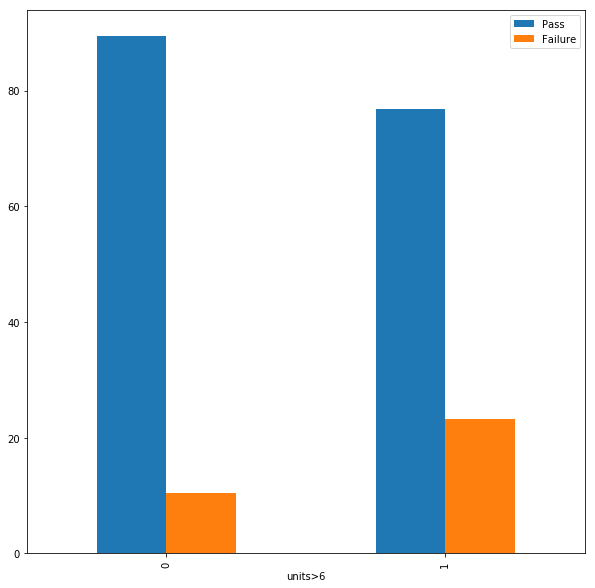

In [20]:
pd.DataFrame(np.c_[df_pivot_units['% Pass'],df_pivot_units['% Fail']], 
             index=df_pivot_units.index).plot(kind='bar',figsize=(10,10))
plt.legend(['Pass','Failure'])

This new feature might help in providing a general picture , showing that in general, when the number of units are more, there is an increase in the failure of delivery.

### 4. Facility

In [21]:
df_pivot_facility = df.pivot_table(values='order_id',index='facility',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_facility['Total']=df_pivot_facility['FAIL']+df_pivot_facility['PASS']
df_pivot_facility['% Pass'] = (df_pivot_facility['PASS']/df_pivot_facility['Total'])*100
df_pivot_facility['% Fail'] = (df_pivot_facility['FAIL']/df_pivot_facility['Total'])*100
df_pivot_facility

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
facility,,,,,
ANTWERP,1082,9171,10253,89.446991,10.553009
AUGSBURG,2592,23574,26166,90.094015,9.905985
EINDHOVEN,2412,16125,18537,86.988186,13.011814
HANOVER,1809,15730,17539,89.685843,10.314157
MANCHESTER,1467,14529,15996,90.828957,9.171043
OXFORD,2229,19394,21623,89.691532,10.308468


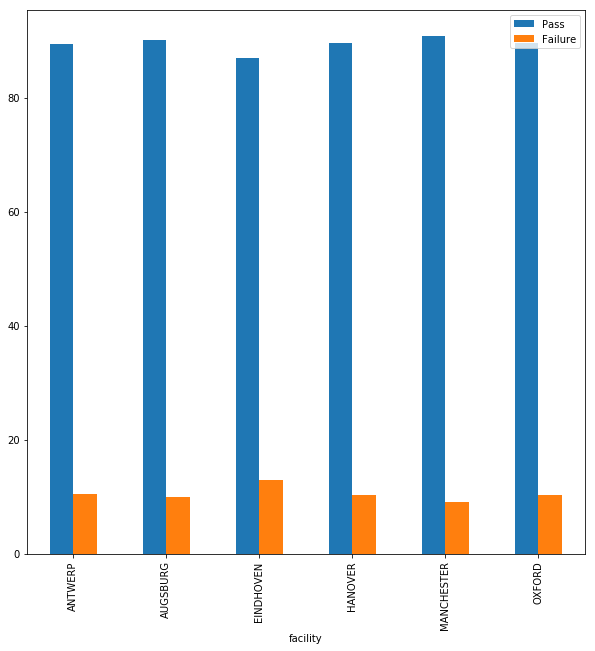

In [22]:
pd.DataFrame(np.c_[df_pivot_facility['% Pass'],df_pivot_facility['% Fail']], 
             index=df_pivot_facility.index).plot(kind='bar',figsize=(10,10))
plt.legend(['Pass','Failure'])

Clearly, there is no significant difference in the failure rate across each facility. This indicates that facility is not a significant factor causing the failure in delivery. 

The highest failure rate is attributed to the Eindhoven, the only fcaility used in Belgium. This is kind of obvious, considering the observed high failure rate in Belgium. 

### 5. Product Category

In [23]:
df_pivot_product_category = df.pivot_table(values='order_id',index='product_category',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_product_category['Total']=df_pivot_product_category['FAIL']+df_pivot_product_category['PASS']
df_pivot_product_category['% Pass'] = (df_pivot_product_category['PASS']/df_pivot_product_category['Total'])*100
df_pivot_product_category['% Fail'] = (df_pivot_product_category['FAIL']/df_pivot_product_category['Total'])*100
df_pivot_product_category

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
product_category,,,,,
ACCESSORIES,708,6976,7684,90.786049,9.213951
JACKETS & VESTS,7356,59983,67339,89.076167,10.923833
TOPS,3527,31564,35091,89.948990,10.051010


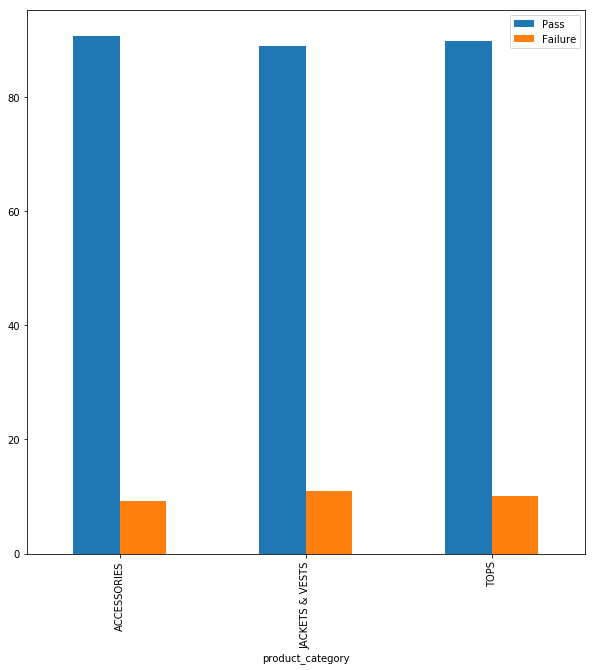

In [24]:
pd.DataFrame(np.c_[df_pivot_product_category['% Pass'],df_pivot_product_category['% Fail']], 
             index=df_pivot_product_category.index).plot(kind='bar',figsize=(10,10))
plt.legend(['Pass','Failure'])

From the above table and figure, it is clear that there is no significant difference in the delay with respect to product category. This indicates that product category is not a significant factor causing the delay in delivery. 

But this is a cumulative summary. We need to validate our assumption across multiple factors

### 6. On_sale

In [25]:
df_pivot_sale = df.pivot_table(values='order_id',index='on_sale',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_sale['Total']=df_pivot_sale['FAIL']+df_pivot_sale['PASS']
df_pivot_sale['% Pass'] = (df_pivot_sale['PASS']/df_pivot_sale['Total'])*100
df_pivot_sale['% Fail'] = (df_pivot_sale['FAIL']/df_pivot_sale['Total'])*100
df_pivot_sale

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
on_sale,,,,,
N,5713,47658,53371,89.295685,10.704315
Y,5878,50865,56743,89.641013,10.358987


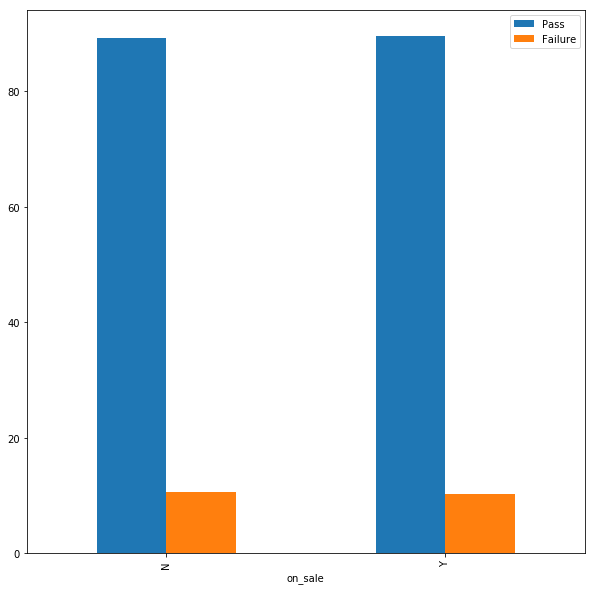

In [26]:
pd.DataFrame(np.c_[df_pivot_sale['% Pass'],df_pivot_sale['% Fail']], 
             index=df_pivot_sale.index).plot(kind='bar',figsize=(10,10))
plt.legend(['Pass','Failure'])

From the above table and figure, it is clear that there is no significant difference in the delay with respect to on-sale feature of the order. This indicates that product category is not a significant factor causing the delay in delivery. 

But this is a cumulative summary. We need to validate our assumption across multiple factors

### 7. Transit_days

In [27]:
df_pivot_transit_days = df.pivot_table(values='order_id',index='transit_days',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_transit_days['Total']=df_pivot_transit_days['FAIL']+df_pivot_transit_days['PASS']
df_pivot_transit_days['% Pass'] = (df_pivot_transit_days['PASS']/df_pivot_transit_days['Total'])*100
df_pivot_transit_days['% Fail'] = (df_pivot_transit_days['FAIL']/df_pivot_transit_days['Total'])*100
df_pivot_transit_days

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
transit_days,,,,,
1,3228,22278,25506,87.344154,12.655846
2,3301,27222,30523,89.185205,10.814795
3,4550,43747,48297,90.579125,9.420875
4,276,2797,3073,91.018549,8.981451
5,100,550,650,84.615385,15.384615
6,22,225,247,91.093117,8.906883
7,67,729,796,91.582915,8.417085
8,47,975,1022,95.401174,4.598826


Text(0.5,0,'Transit Days')

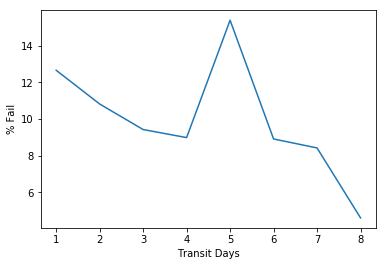

In [28]:
sns.lineplot(range(1,len(df_pivot_transit_days)+1),'% Fail',data=df_pivot_transit_days)
plt.xlabel('Transit Days')

Except in the case of 5-day transit period, there is a general decreasing trend in the failure rate as the transit period increases. This clearly shows that when the transit days are appropriately planned, failure can be avoided.

### 8. Backorder

In [29]:
df_pivot_backorder = df.pivot_table(values='order_id',index='backorder',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_backorder['Total']=df_pivot_backorder['FAIL']+df_pivot_backorder['PASS']
df_pivot_backorder['% Pass'] = (df_pivot_backorder['PASS']/df_pivot_backorder['Total'])*100
df_pivot_backorder['% Fail'] = (df_pivot_backorder['FAIL']/df_pivot_backorder['Total'])*100
df_pivot_backorder

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
backorder,,,,,
N,9430,88574,98004,90.377944,9.622056
Y,2161,9949,12110,82.155244,17.844756


Backorder is an attribute defining if the order has to be sourced from the same place or from a different place.It was mentioned that this was not taken into consideration while planning the delivery.

Clearly, this is a major flaw in terms of planning. This can be clearly observed from the above significant difference in the failure rate. 

### 9. Returned 

In [30]:
df_pivot_returned = df.pivot_table(values='order_id',index='returned',
                                           columns='delivered_to_plan',aggfunc=len)
df_pivot_returned['Total']=df_pivot_returned['FAIL']+df_pivot_returned['PASS']
df_pivot_returned['% Pass'] = (df_pivot_returned['PASS']/df_pivot_returned['Total'])*100
df_pivot_returned['% Fail'] = (df_pivot_returned['FAIL']/df_pivot_returned['Total'])*100
df_pivot_returned

delivered_to_plan,FAIL,PASS,Total,% Pass,% Fail
returned,,,,,
N,9779,84944,94723,89.676214,10.323786
Y,1812,13579,15391,88.226886,11.773114


Returned is an order attribute that is showing if the order is returned order. From the above table, it is clear that there is no significant difference in the delay with respect to this feature of the order. This indicates that returned is not a significant factor causing delay in delivery. 

In [31]:
def final_flag(x):
    if(x=='PASS'):
        return 0
    else:
        return 1
df['final_flag']=df['delivered_to_plan'].apply(lambda x:final_flag(x))

In [32]:
df.columns

Index(['order_id', 'country', 'shipping_method', 'units_per_order', 'facility',
       'product_category', 'on_sale', 'transit_days', 'returned', 'backorder',
       'datetime_ordered', 'datetime_sourced', 'datetime_product_ready',
       'datetime_planned', 'datetime_delivered', 'deadline_source',
       'deadline_make', 'deadline_deliver', 'delivered_to_plan', 'units>6',
       'final_flag'],
      dtype='object')

## New Features - Feature Engineering

In the given data, timestamps were provided for end of each step along with their deadlines. 

Some assumptions were made before deriving these new features.
1. There is no lag in planning phase
2. As soon as the order is placed, the planned date of delivery is determined by certain rules.
3. The Actual Deadline for a step can be determined by adding the deadline to the timestamp at the end of the previous step.
4. The lag can be determined by the difference in the actual delivery timestamp and the determined deadline( computed in the previous step)
5. All the steps are independent of each other, i.e the delay in one step is not affecting the subsequent steps.
6. A plan is called a Bad plan, when there is no delay in any of the steps and still there is a failure in delivery.


In [33]:
df['deadline_source'] = pd.to_timedelta(df['deadline_source'],'m')
df['deadline_make']=pd.to_timedelta(df['deadline_make'],'h')
df['deadline_deliver']=pd.to_timedelta(df['deadline_deliver'],'d')

In [34]:
df.dtypes

order_id                           object
country                            object
shipping_method                    object
units_per_order                     int64
facility                           object
product_category                   object
on_sale                            object
transit_days                        int64
returned                           object
backorder                          object
datetime_ordered           datetime64[ns]
datetime_sourced           datetime64[ns]
datetime_product_ready     datetime64[ns]
datetime_planned           datetime64[ns]
datetime_delivered         datetime64[ns]
deadline_source           timedelta64[ns]
deadline_make             timedelta64[ns]
deadline_deliver          timedelta64[ns]
delivered_to_plan                  object
units>6                             int64
final_flag                          int64
dtype: object

In [35]:
## Actual Sourced Deadline = ordered + source deadline
df['actual_sourced'] = df['datetime_ordered']+df['deadline_source']
df['actual_make'] = df['datetime_sourced']+df['deadline_make']
df['actual_deliver'] = df['datetime_product_ready']+df['deadline_deliver']

In [36]:
df['source_delay'] = df['actual_sourced']-df['datetime_sourced']
df['make_delay']=df['actual_make']-df['datetime_product_ready']
df['delivery_delay'] = df['actual_deliver']-df['datetime_delivered']

In [37]:
def flag(x):
    if(x.days<0):
        return 1
    else:
        return 0

In [38]:
df['source_delay_flag']=df['source_delay'].apply(lambda x:flag(x))
df['make_delay_flag']=df['make_delay'].apply(lambda x:flag(x))
df['delivery_delay_flag']=df['delivery_delay'].apply(lambda x:flag(x))

In [39]:
df['final_flag']=df['delivered_to_plan'].apply(lambda x:final_flag(x))

In [40]:
df['Bad_Plan']=df['source_delay_flag']+df['make_delay_flag']+df['delivery_delay_flag']-df['final_flag']

In [41]:
df['Bad_Plan'].unique()

array([ 1,  0,  2, -1,  3], dtype=int64)

In [42]:
def bad_plan(x):
    if(x<0):
        return 1
    else:
        return 0

In [43]:
df['Bad_Plan']=df['Bad_Plan'].apply(lambda x:bad_plan(x))

In [44]:
df['Delay_Days'] = (df['datetime_delivered']-df['datetime_planned'])

In [45]:
## Converting everything in minutes - Total Delay, source_delay, make_delay, delivery_delay
df['make_delay_minutes']=df['make_delay']/np.timedelta64(1,'m')
df['source_delay_minutes']=df['source_delay']/np.timedelta64(1,'m')
df['delivery_delay_minutes']=df['delivery_delay']/np.timedelta64(1,'m')
df['Total_delay_minutes']=df['Delay_Days']/np.timedelta64(1,'m')

#### 1.1 Analysis for Belgium Alone 
Here I have subfiltered the records for Belgium alone and checked for the delay. 

In [46]:
df_belgium = df[df['country']=='BELGIUM']
df_belgium_fail = df_belgium[df_belgium['delivered_to_plan']=='FAIL']
df_belgium.columns

Index(['order_id', 'country', 'shipping_method', 'units_per_order', 'facility',
       'product_category', 'on_sale', 'transit_days', 'returned', 'backorder',
       'datetime_ordered', 'datetime_sourced', 'datetime_product_ready',
       'datetime_planned', 'datetime_delivered', 'deadline_source',
       'deadline_make', 'deadline_deliver', 'delivered_to_plan', 'units>6',
       'final_flag', 'actual_sourced', 'actual_make', 'actual_deliver',
       'source_delay', 'make_delay', 'delivery_delay', 'source_delay_flag',
       'make_delay_flag', 'delivery_delay_flag', 'Bad_Plan', 'Delay_Days',
       'make_delay_minutes', 'source_delay_minutes', 'delivery_delay_minutes',
       'Total_delay_minutes'],
      dtype='object')

Text(0.5,1,'In Depth Analysis in Belgium')

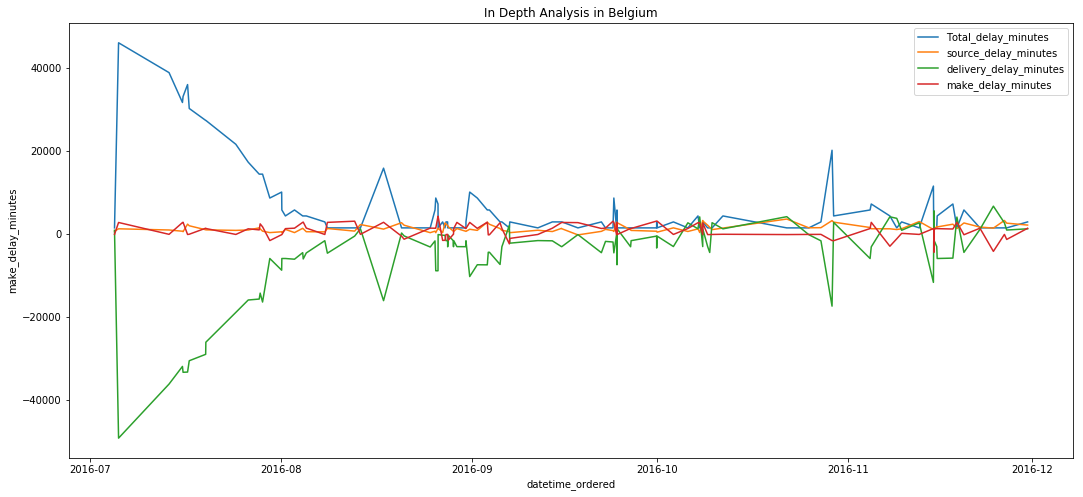

In [47]:
plt.figure(figsize=(18,8))
sns.lineplot('datetime_ordered','Total_delay_minutes',data=df_belgium_fail)
sns.lineplot('datetime_ordered','source_delay_minutes',data=df_belgium_fail)
sns.lineplot('datetime_ordered','delivery_delay_minutes',data=df_belgium_fail)
sns.lineplot('datetime_ordered','make_delay_minutes',data=df_belgium_fail)
plt.legend(['Total_delay_minutes','source_delay_minutes','delivery_delay_minutes','make_delay_minutes'])
plt.title("In Depth Analysis in Belgium")

Clearly, from the above plot, <b>Delivery Delay</b> is the most significant feature in case of failure in Belgium. Moreover, there is a mild trend that can be observed in terms of delivery delay. It can be observed that there is a delivery delay that is happening mostly in the beginning of the month or end of the month. Even when the planning is good enough, the failure is occuring due to delivery delay.

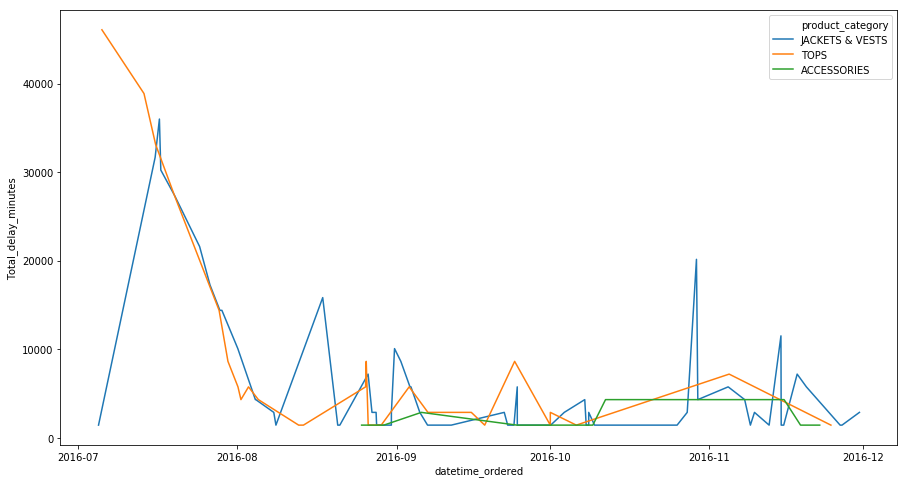

In [48]:
plt.figure(figsize=(15,8))
sns.lineplot('datetime_ordered','Total_delay_minutes',data=df_belgium_fail,hue='product_category')

Another important aspect that we can observe is that there is delay associated with products such as Jackets & Vests and Tops. The possible reason behind this could be the size of the package. Usually accessories are small in size and jackets/tops could be heavier. 

Coming to other factors, Belgium has a uniform facility and shipping method. 

### Failure Analysis across time

C:\Users\pooji\Anaconda3_new\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


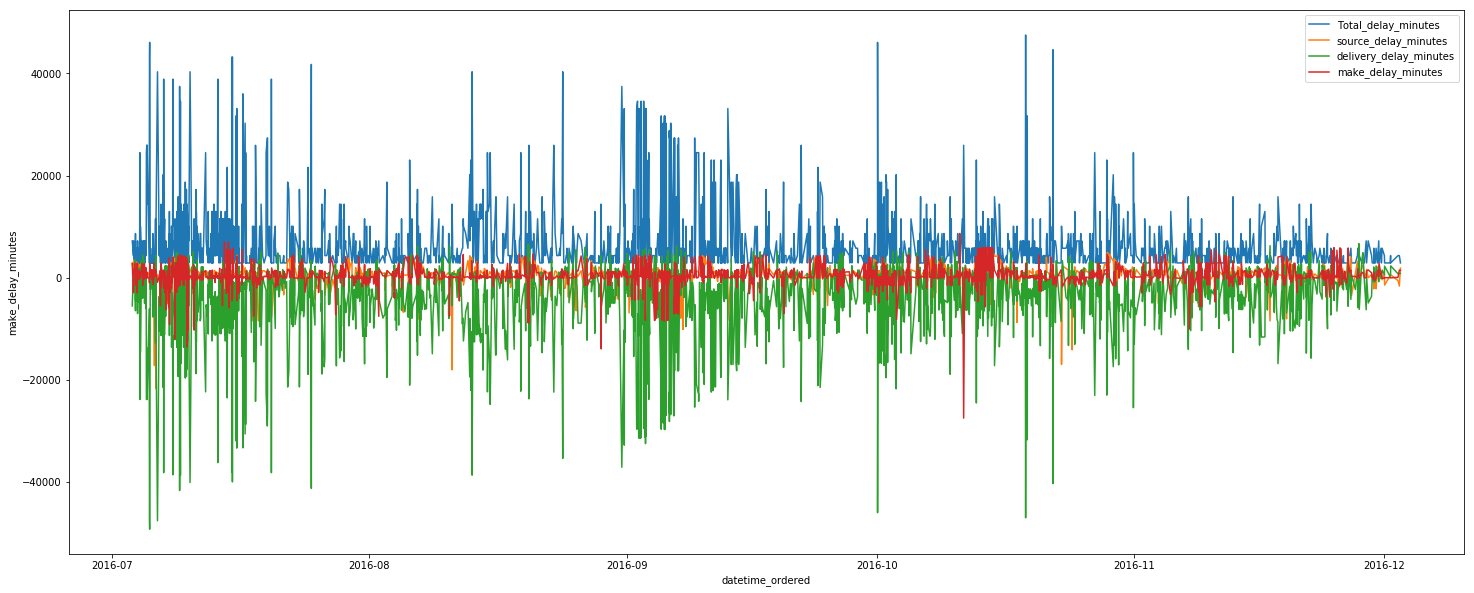

In [49]:
plt.figure(figsize=(25,10))
df_fail = df[df['delivered_to_plan']=='FAIL']
df_fail_upper = df_fail[df_fail['Total_delay_minutes']>df_fail['Total_delay_minutes'].median()]
sns.lineplot('datetime_ordered','Total_delay_minutes',data=df_fail_upper)
sns.lineplot('datetime_ordered','source_delay_minutes',data=df_fail_upper)
sns.lineplot('datetime_ordered','delivery_delay_minutes',data=df_fail_upper)
sns.lineplot('datetime_ordered','make_delay_minutes',data=df_fail_upper)
plt.legend(['Total_delay_minutes','source_delay_minutes','delivery_delay_minutes','make_delay_minutes'])



C:\Users\pooji\Anaconda3_new\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


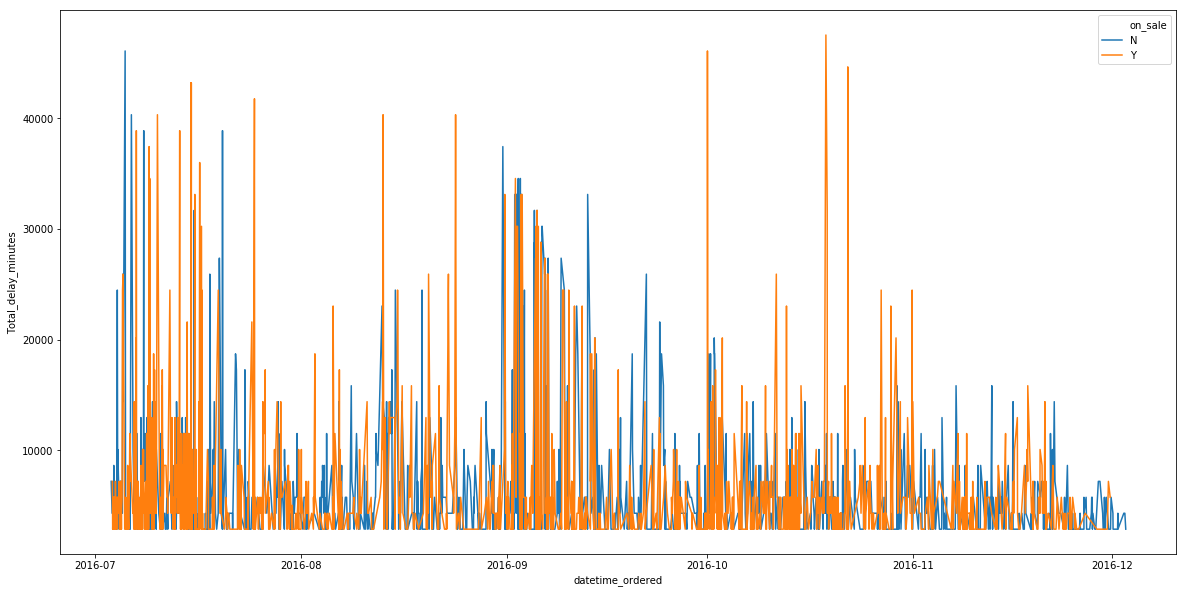

In [50]:
plt.figure(figsize=(20,10))
# sns.lineplot('datetime_ordered','Total_delay_minutes',data=df_fail_upper,hue='shipping_method')
sns.lineplot('datetime_ordered','Total_delay_minutes',data=df_fail_upper,hue='on_sale')

It is clear from the above plot that delays are usually affiliated if the products are on sale. This can be due to the high demand during the sale.

In [51]:
df_heat_map = pd.DataFrame()
df_heat_map['date'] =pd.to_datetime(df_fail_upper['datetime_ordered'])
df_heat_map['month'] = df_heat_map['date'].apply(lambda x: x.month)
df_heat_map['product_category'] = df_fail_upper['product_category']
df_heat_map['shipping_method']=df_fail_upper['shipping_method']
df_heat_map['total_delay']=df_fail_upper['Total_delay_minutes']
df_heat_map['country']=df_fail_upper['country']

In [52]:
df_pivot_heat_shipping = df_heat_map.pivot_table(values='total_delay',index='month',
                                           columns='shipping_method',aggfunc=np.mean)

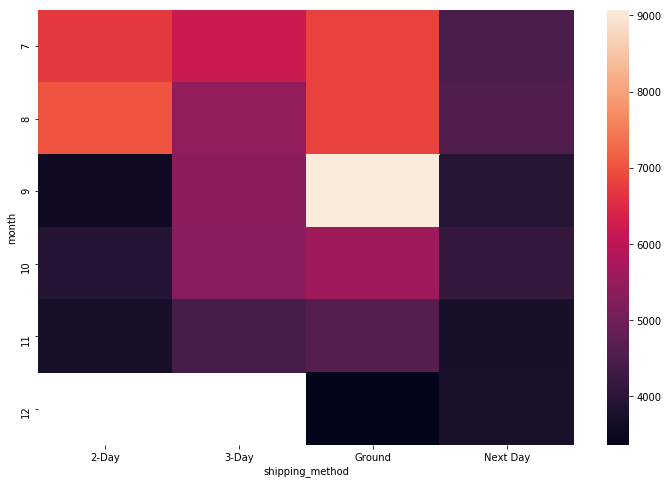

In [53]:
plt.figure(figsize=(12,8))
sns.heatmap(df_pivot_heat_shipping)

In [54]:
df_pivot_source_delay = df.pivot_table(values='order_id',index='delivered_to_plan',
                                           columns='source_delay_flag',aggfunc=len)
df_pivot_source_delay['Percentages_source_delay']=df_pivot_source_delay[1]/df_pivot_source_delay.sum(axis=1)
df_pivot_source_delay['Percentages_no_source_delay']=df_pivot_source_delay[0]/df_pivot_source_delay.sum(axis=1)
df_pivot_source_delay.head()

source_delay_flag,0,1,Percentages_source_delay,Percentages_no_source_delay
delivered_to_plan,,,,
FAIL,9620,1971,0.170046,0.829942
PASS,93538,4985,0.050597,0.949402


Clearly, there is a significant difference in the pass and failure rates when there is a delay in the sourcing

In [55]:
df_pivot_make_delay = df.pivot_table(values='order_id',index='delivered_to_plan',
                                           columns='make_delay_flag',aggfunc=len)
df_pivot_make_delay['Percentages_make_delay']=df_pivot_make_delay[1]/df_pivot_make_delay.sum(axis=1)
df_pivot_make_delay['Percentages_no_make_delay']=df_pivot_make_delay[0]/df_pivot_make_delay.sum(axis=1)
df_pivot_make_delay.head()

make_delay_flag,0,1,Percentages_make_delay,Percentages_no_make_delay
delivered_to_plan,,,,
FAIL,8356,3235,0.279096,0.720887
PASS,77779,20744,0.210550,0.789448


Clearly, there is a significant difference in the pass and failure rates when there is a delay in the making

In [56]:
df_pivot_delivery_delay = df.pivot_table(values='order_id',index='delivered_to_plan',
                                           columns='delivery_delay_flag',aggfunc=len)
df_pivot_delivery_delay['Percentages_make_delay']=df_pivot_delivery_delay[1]/df_pivot_delivery_delay.sum(axis=1)
df_pivot_delivery_delay['Percentages_no_make_delay']=df_pivot_delivery_delay[0]/df_pivot_delivery_delay.sum(axis=1)
df_pivot_delivery_delay.head()

delivery_delay_flag,0,1,Percentages_make_delay,Percentages_no_make_delay
delivered_to_plan,,,,
FAIL,6441,5150,0.44431,0.555668
PASS,90117,8406,0.08532,0.914679


Though there is not much of a significant difference in case of failure rates, in the success rate, delivery delay plays a significant role.

In [57]:
df_pivot_bad_plan = df.pivot_table(values='order_id',index='delivered_to_plan',
                                           columns='Bad_Plan',aggfunc=len)
df_pivot_bad_plan['Percentages_bad_plan']=df_pivot_bad_plan[1]/df_pivot_bad_plan.sum(axis=1)
df_pivot_bad_plan['Percentages_no_bad_plan']=df_pivot_bad_plan[0]/df_pivot_bad_plan.sum(axis=1)
df_pivot_bad_plan.head()

Bad_Plan,0,1,Percentages_bad_plan,Percentages_no_bad_plan
delivered_to_plan,,,,
FAIL,8619.0,2972.0,0.256406,0.743578
PASS,98523.0,NaN,NaN,1.000000


Since there are no succesful cases with a Bad plan, it is clearly an important factor. Even in the failure rates, the percentages of cases with a bad plan are comparitively less than the percentage of cases without a bad plan. This clearly suggests that there might be other reasons involved along with bad plan. 

Moreover, in our case, we are considering all the steps as independent. However, in the real world, it is unlikely that these steps are independent of each other. They are generally highly independent and usually cascading. This makes them correlated as well. We can explore more about this in the following section.

# <u>Final Conclusions from the above data analysis</u>
## From the above data analysis, there are some key conclusions we can draw about the causes of failure in delivery.

### 1. The primary cause of delay can be observed as delay in delivery phase. This can be due to various reasons. 
### 2. This can also be substantiated through the analysis of shipping method. There is a significant effect of shipping method in the failure rate. The failure rate is high in case of Next-day and 2-Day delivery.
### 3. Backorder is another attribute that is highly significant in terms of determining the failure. This is because it is not considered when the milestones are planned(Given). This will greatly affect the sourcing delay, causing an overall delay in delivery.